<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/4_2x_intro_to_cnn_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

Great documentation https://pytorch.org/docs/stable/index.html

In [ ]:
import torch
import torch.nn.functional as F

# Warm up

Let's introduce the different functions and inputs we need to use for convolutions in PyTorch. Let's validate the first example we have seen during the lecture.

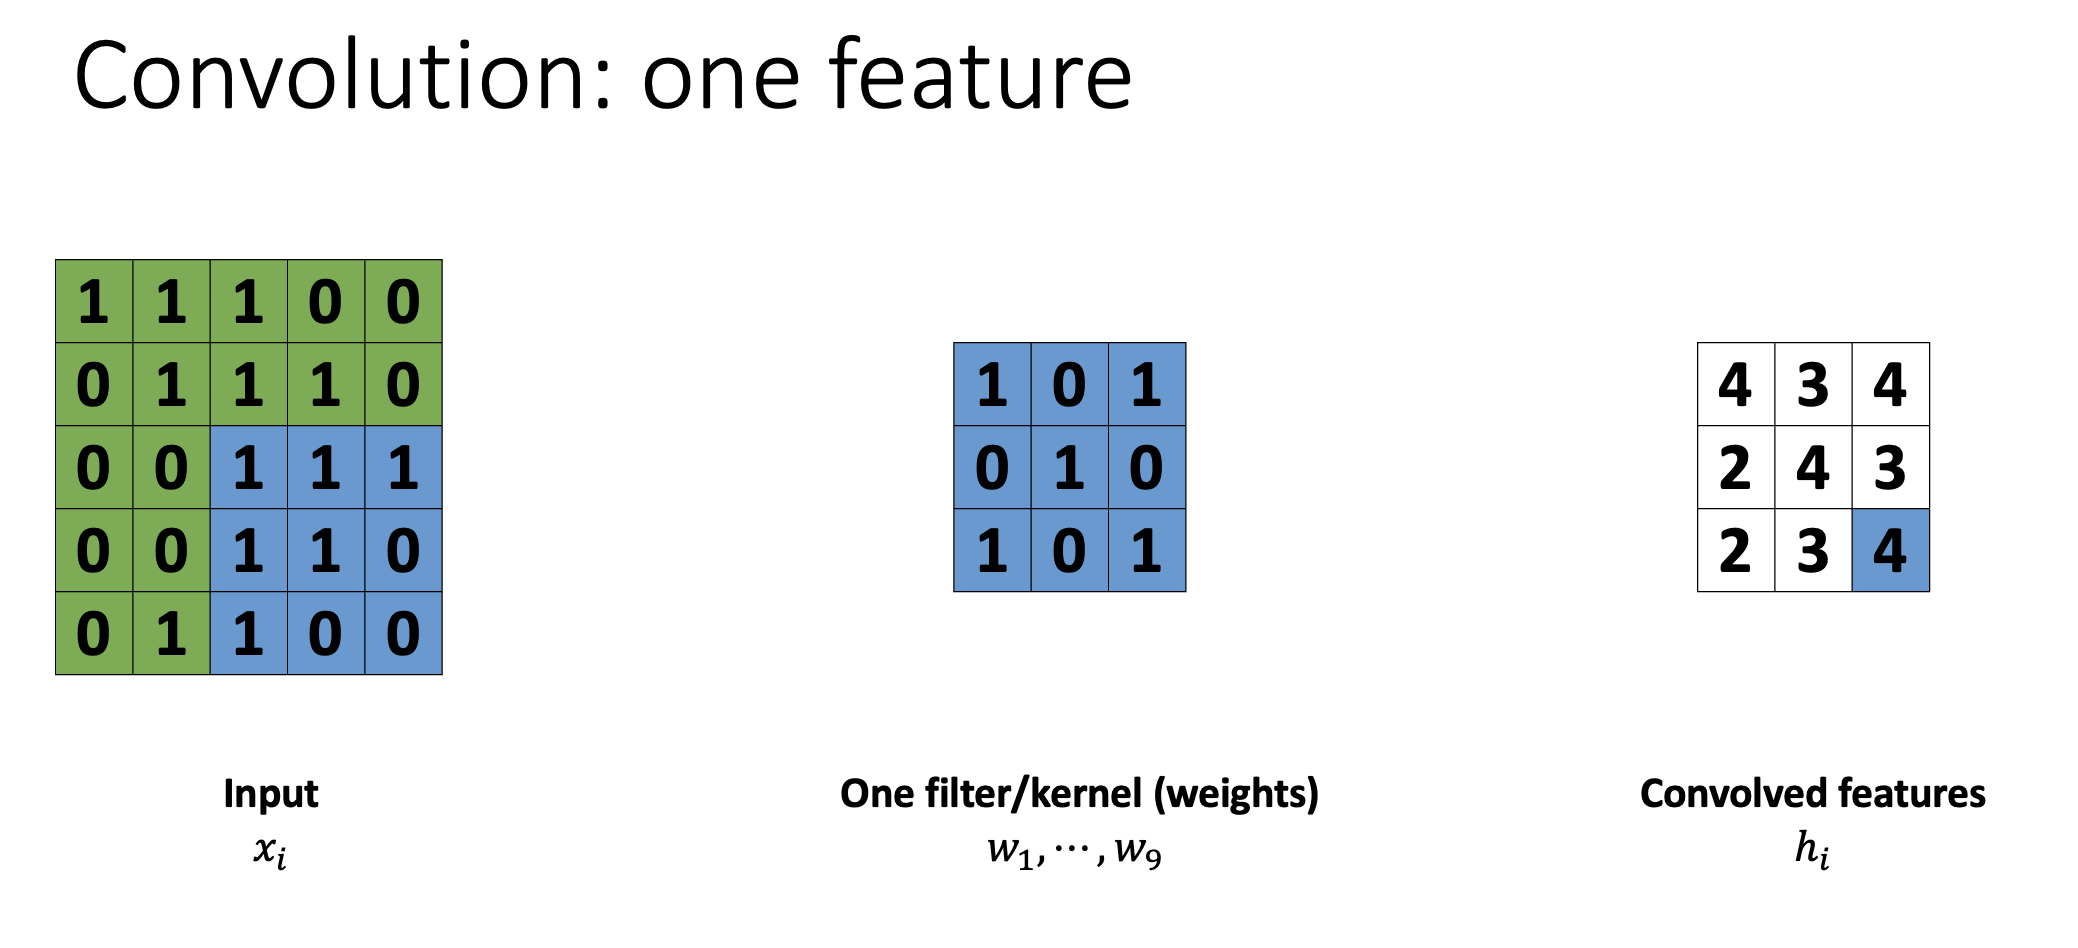

Usually, as input, we would use a batch with multiple samples (to leverage parallelism). However, for simplicity, we will assume there is only one sample in our batch. Regarding the kernel, a convolutional neural network would have several kernels/filters (those are the parameters we aim to learn). Again, for illustration purpose, we will consider only one kernel with fixed weights.

In [ ]:
input_sample = torch.tensor([
  [1, 1, 1, 0, 0],
  [0, 1, 1, 1, 0],
  [0, 0, 1, 1, 1],
  [0, 0, 1, 1, 0],
  [0, 1, 1, 0, 0]
]).float()
input_sample

tensor([[1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 0.]])

In [ ]:
kernel = torch.tensor([
  [1, 0, 1],
  [0, 1, 0],
  [1, 0, 1],
]).float()
kernel

tensor([[1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]])

We can confirm that the input vector and the kernel look like the ones above.

Another important notion with convolution is the notion of "channel". Typically, an image is composed of three channels. One corresponds to the "red" component, another for the "green" component, and the last for the "blue" one. For each pixel, it has a value between 0 and 255 to denote the intensity of the color (red, green, and blue separately). For example (from https://commons.wikimedia.org/wiki/File:RGB_channels_separation.png):

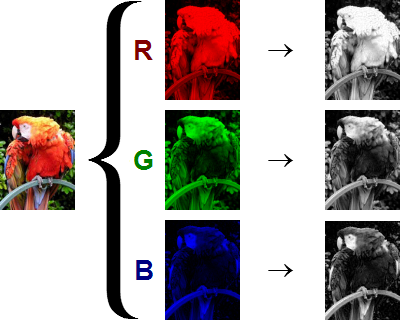

Note that in practice, we normalize the values between 0 and 1 (instead of 0 and 255).

For text data, such notion does not exist and thus, we use only **one** channel!


Let's go back to our example and assume a batch size of 1 with a single channel. We will use the function `unsqueeze()` that adds an extra dimension to the tensor.

In [ ]:
input_sample = input_sample.unsqueeze(0).unsqueeze(0) # We add a dimension for 1 channel and another for the batch size = 1
kernel = kernel.unsqueeze(0).unsqueeze(0) # Here we do the same operation as we consider only one weight
input_sample.size(),  # batch x nb_channels x width x height. For NLP, it would be batch x 1 x nb_words x word_embedding dim
kernel.size() # nb_weights x nb_channels x window_size x window_size

torch.Size([1, 1, 3, 3])

It's time to apply a convolution! In PyTorch, a 2D convolution can be done with ``conv2d()`` (check the documentation here https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html?highlight=conv2d#torch.nn.functional.conv2d). The first parameter denotes the batch and the second the filters (here only one and one, but it would not change the code if we had more).

In [ ]:
output = F.conv2d(input_sample, kernel)
output, output.size()

(tensor([[[[4., 3., 4.],
           [2., 4., 3.],
           [2., 3., 4.]]]]), torch.Size([1, 1, 3, 3]))

Note the dimension of the output! 

As we have seen in the course, we can also specify the padding, the stride, and the dilation. For each of those, we can (optionnally) provide their values using the following notation: `attribute=(x,y)`. In some cases, we might want to act only on one dimension and set `x=0`or `y=0`.

To replicate the above example with the full notation, here would be the command.

In [ ]:
F.conv2d(input_sample, kernel, stride=(1,1), padding=(0,0), dilation=(1,1))

tensor([[[[4., 3., 4.],
          [2., 4., 3.],
          [2., 3., 4.]]]])

# Padding

Before applying the padding to the convolution, let's pad the input vector to understand better how it works. We can use the function `pad()`. 

In Conv2d, the padding will be *symmetric* by default, meaning that `padding=(a,b)` will pad the vector with "a"s on the left and right and similarly with "b"s on the top and bottom. In the function `pad()`, we have to set the padding for each direction (left, right, top, bottom).

Let's see some examples

In [ ]:
F.pad(input_sample, (0,0,0,0), value=9)

tensor([[[[1., 1., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 1., 0.],
          [0., 1., 1., 0., 0.]]]])

In [ ]:
F.pad(input_sample, (1,0,0,0), value=9)

tensor([[[[9., 1., 1., 1., 0., 0.],
          [9., 0., 1., 1., 1., 0.],
          [9., 0., 0., 1., 1., 1.],
          [9., 0., 0., 1., 1., 0.],
          [9., 0., 1., 1., 0., 0.]]]])

In [ ]:
F.pad(input_sample, (0,1,0,0), value=9)

tensor([[[[1., 1., 1., 0., 0., 9.],
          [0., 1., 1., 1., 0., 9.],
          [0., 0., 1., 1., 1., 9.],
          [0., 0., 1., 1., 0., 9.],
          [0., 1., 1., 0., 0., 9.]]]])

In [ ]:
F.pad(input_sample, (0,0,1,0), value=9)

tensor([[[[9., 9., 9., 9., 9.],
          [1., 1., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 1., 0.],
          [0., 1., 1., 0., 0.]]]])

In [ ]:
F.pad(input_sample, (0,0,0,1), value=9)

tensor([[[[1., 1., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 1., 0.],
          [0., 1., 1., 0., 0.],
          [9., 9., 9., 9., 9.]]]])

In [ ]:
F.pad(input_sample, (1,1,0,0), value=9)

tensor([[[[9., 1., 1., 1., 0., 0., 9.],
          [9., 0., 1., 1., 1., 0., 9.],
          [9., 0., 0., 1., 1., 1., 9.],
          [9., 0., 0., 1., 1., 0., 9.],
          [9., 0., 1., 1., 0., 0., 9.]]]])

In [ ]:
F.pad(input_sample, (0,0,1,1), value=9)

tensor([[[[9., 9., 9., 9., 9.],
          [1., 1., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 1., 0.],
          [0., 1., 1., 0., 0.],
          [9., 9., 9., 9., 9.]]]])

## Exercise

Now let's come back to the example in the course. How would we reproduce the following?

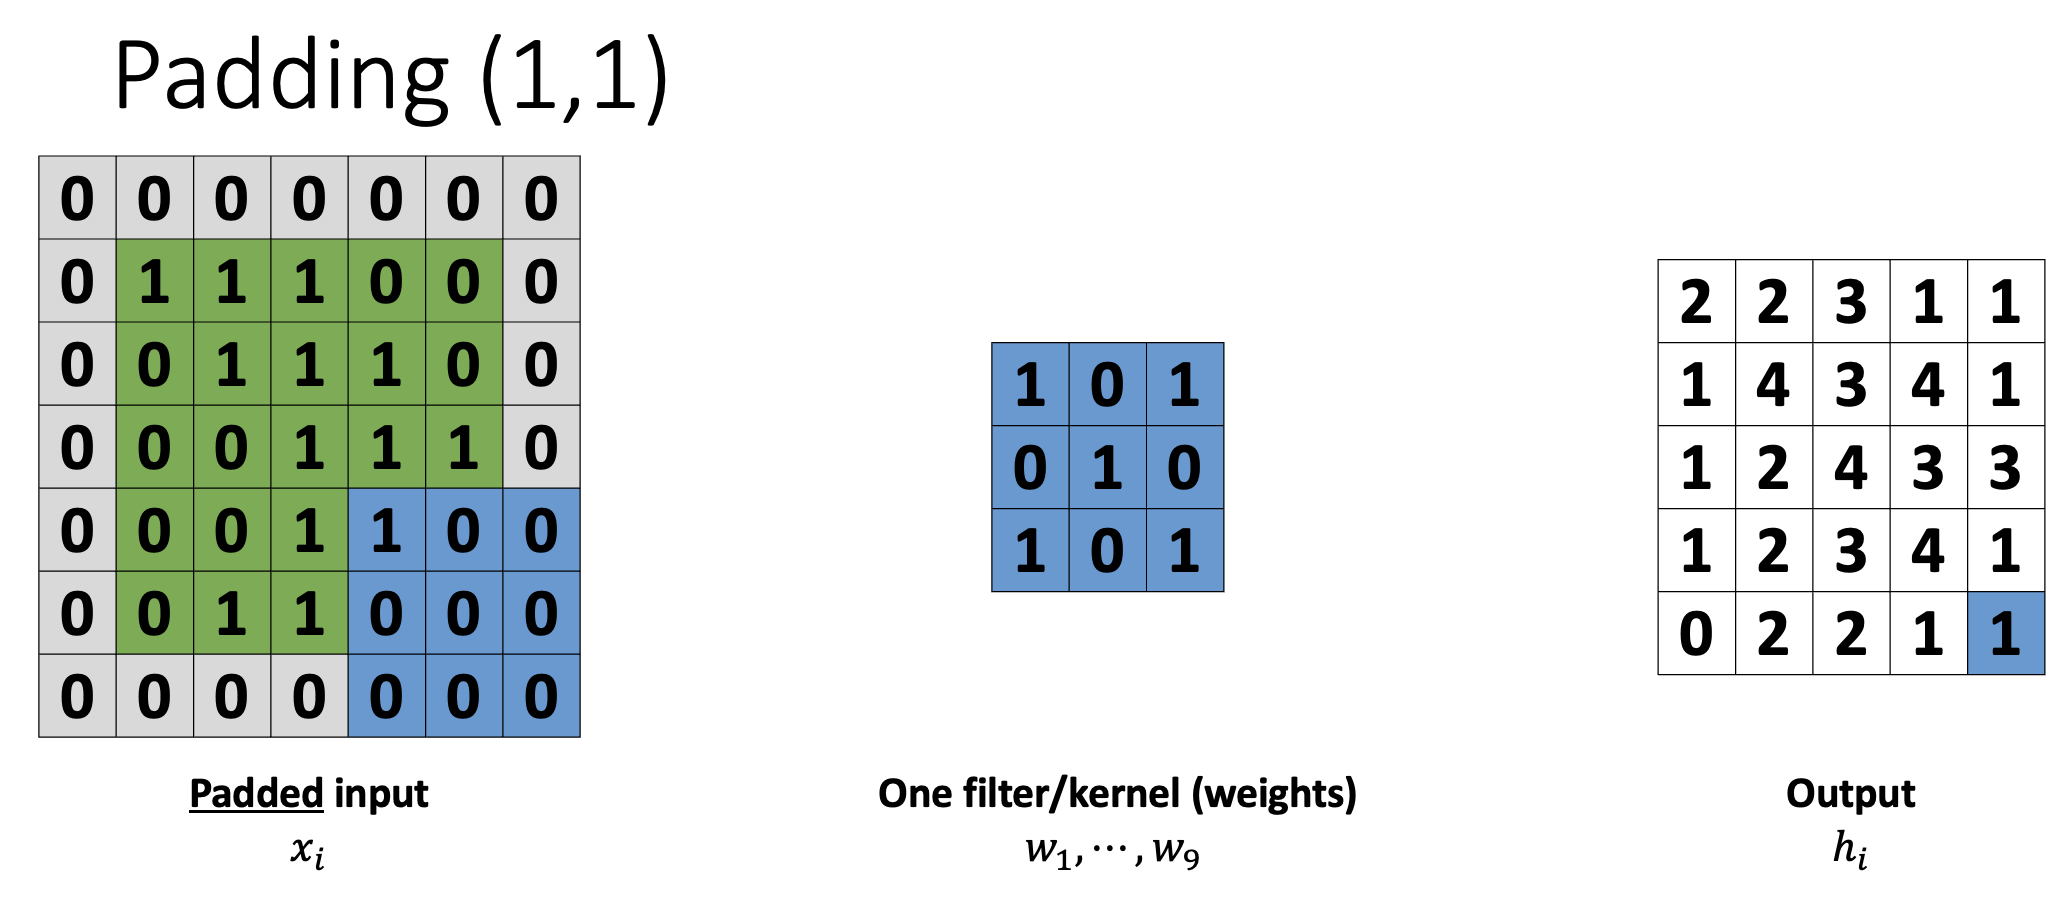

In [ ]:
#@title Solution padding
F.conv2d(input_sample, kernel, stride=(1,1), padding=(1,1), dilation=(1,1))

tensor([[[[2., 2., 3., 1., 1.],
          [1., 4., 3., 4., 1.],
          [1., 2., 4., 3., 3.],
          [1., 2., 3., 4., 1.],
          [0., 2., 2., 1., 1.]]]])

Note that the output has the same dimension as the input in this case! Padding is a nice way to achieve this and faciliate the dimensions for the next parts of your model.

# Stride

We have seen in the course that we do not have to move the window 1 by 1. We can control the behavior with the parameter `stride=(x,y)`

Let's replicate the example in the class

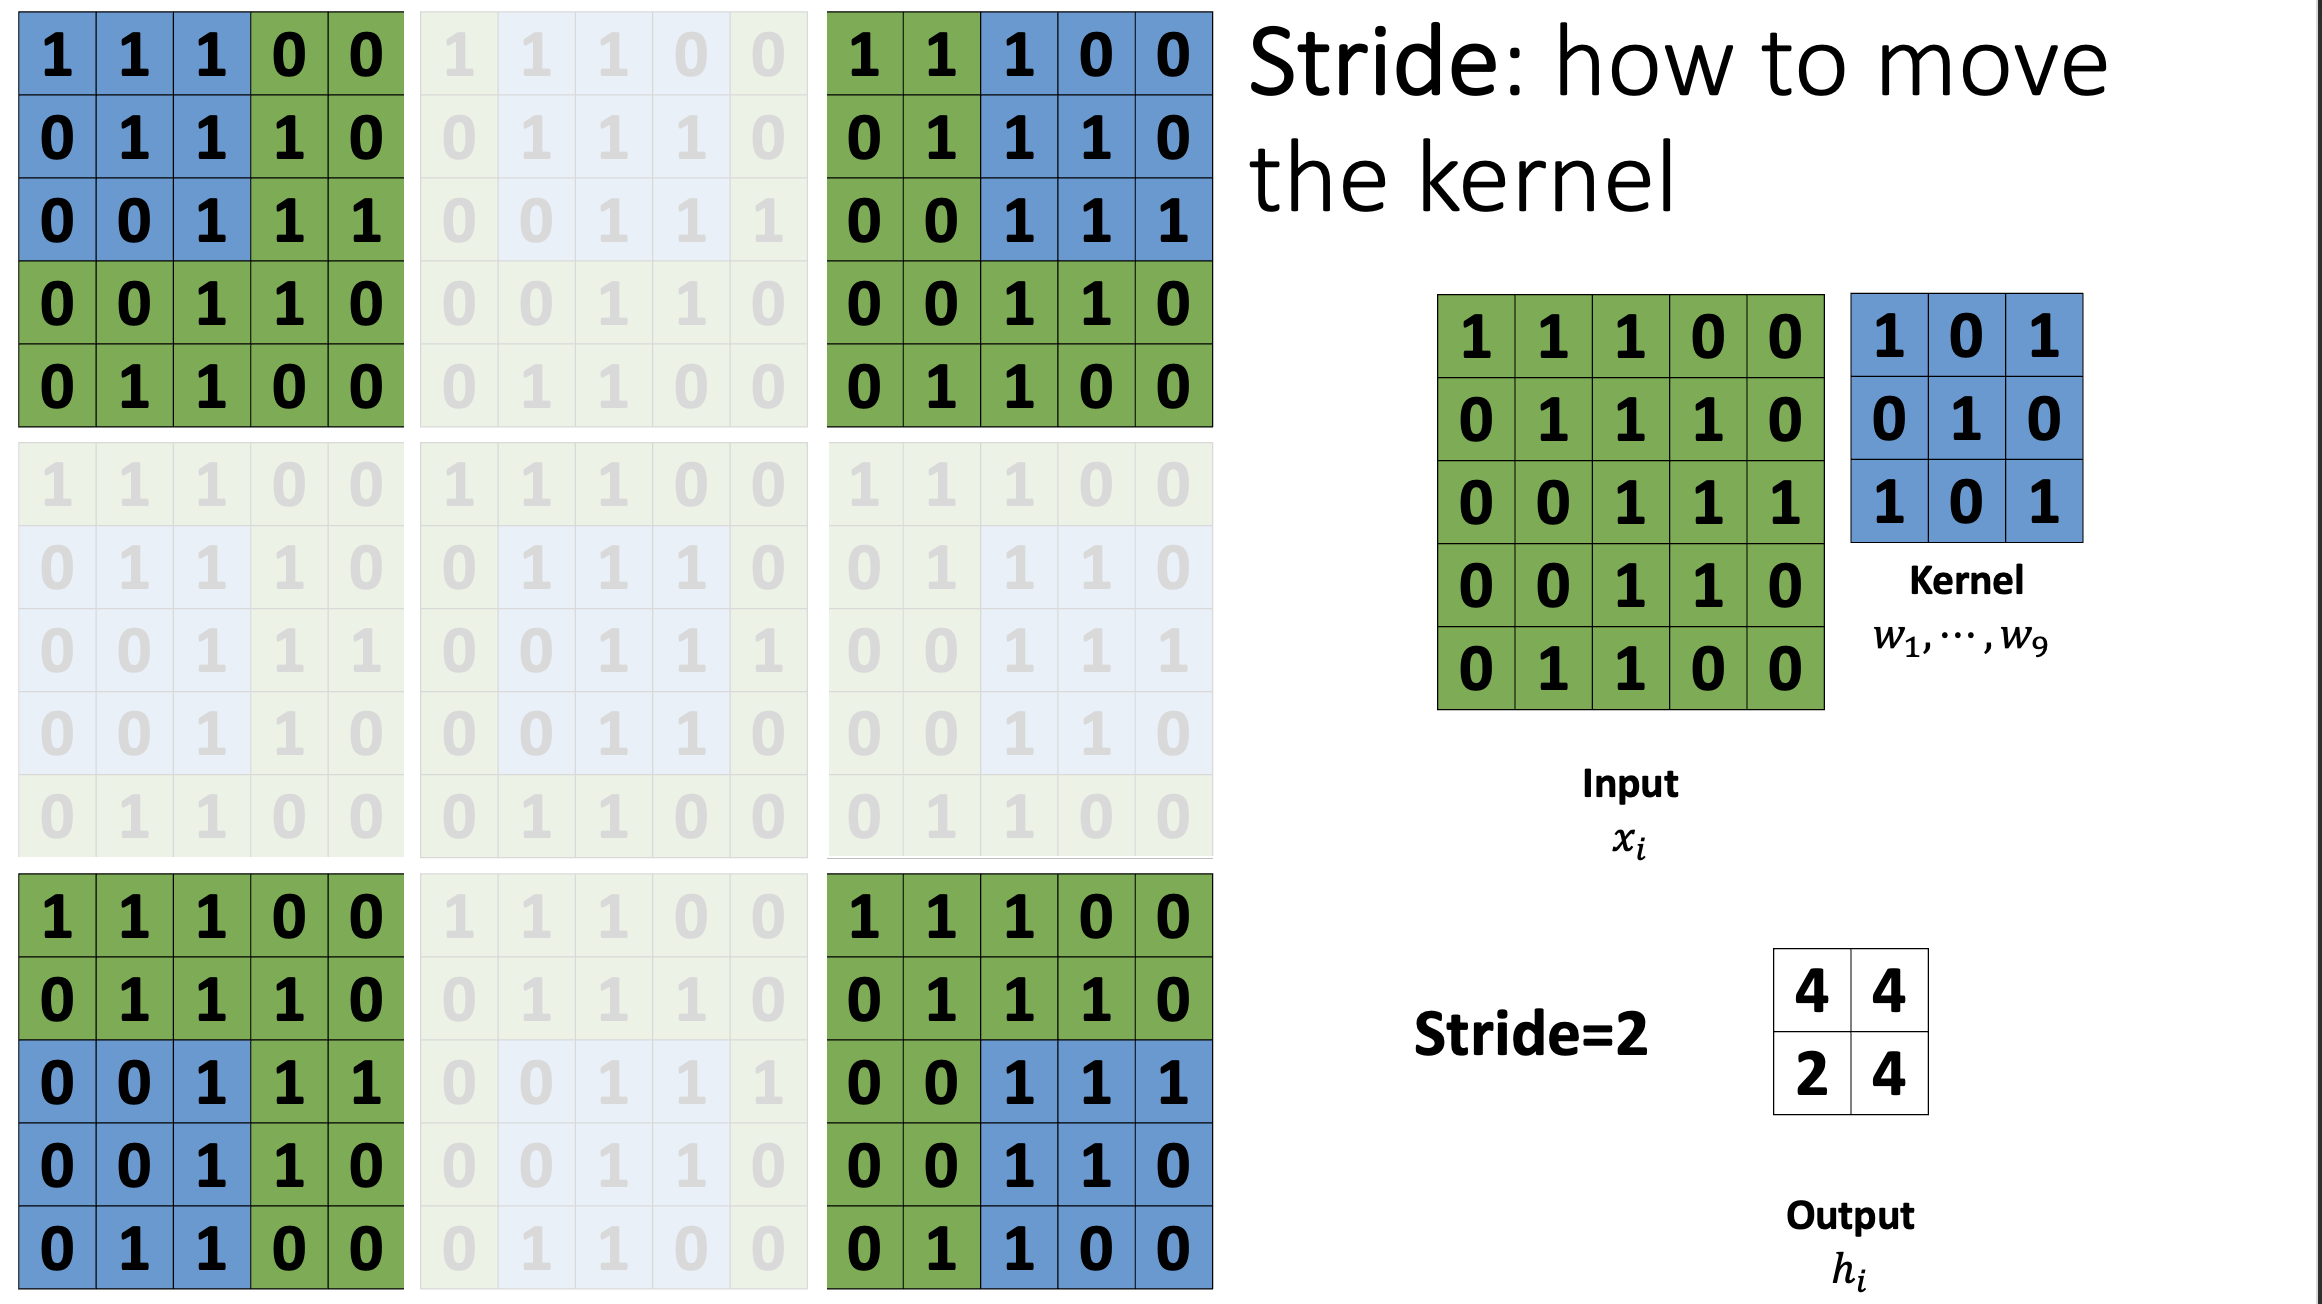

In [ ]:
F.conv2d(input_sample, kernel, stride=(2,2), padding=(0,0), dilation=(1,1))

tensor([[[[4., 4.],
          [2., 4.]]]])

Let's see what would happen if we move only by 2 on the x or y axis

In [ ]:
F.conv2d(input_sample, kernel, stride=(2,1), padding=(0,0), dilation=(1,1))

tensor([[[[4., 3., 4.],
          [2., 3., 4.]]]])

In [ ]:
F.conv2d(input_sample, kernel, stride=(1,2), padding=(0,0), dilation=(1,1))

tensor([[[[4., 4.],
          [2., 3.],
          [2., 4.]]]])

Note how the stride changes the dimension of the output

## Exercise

How would we reproduce the following?

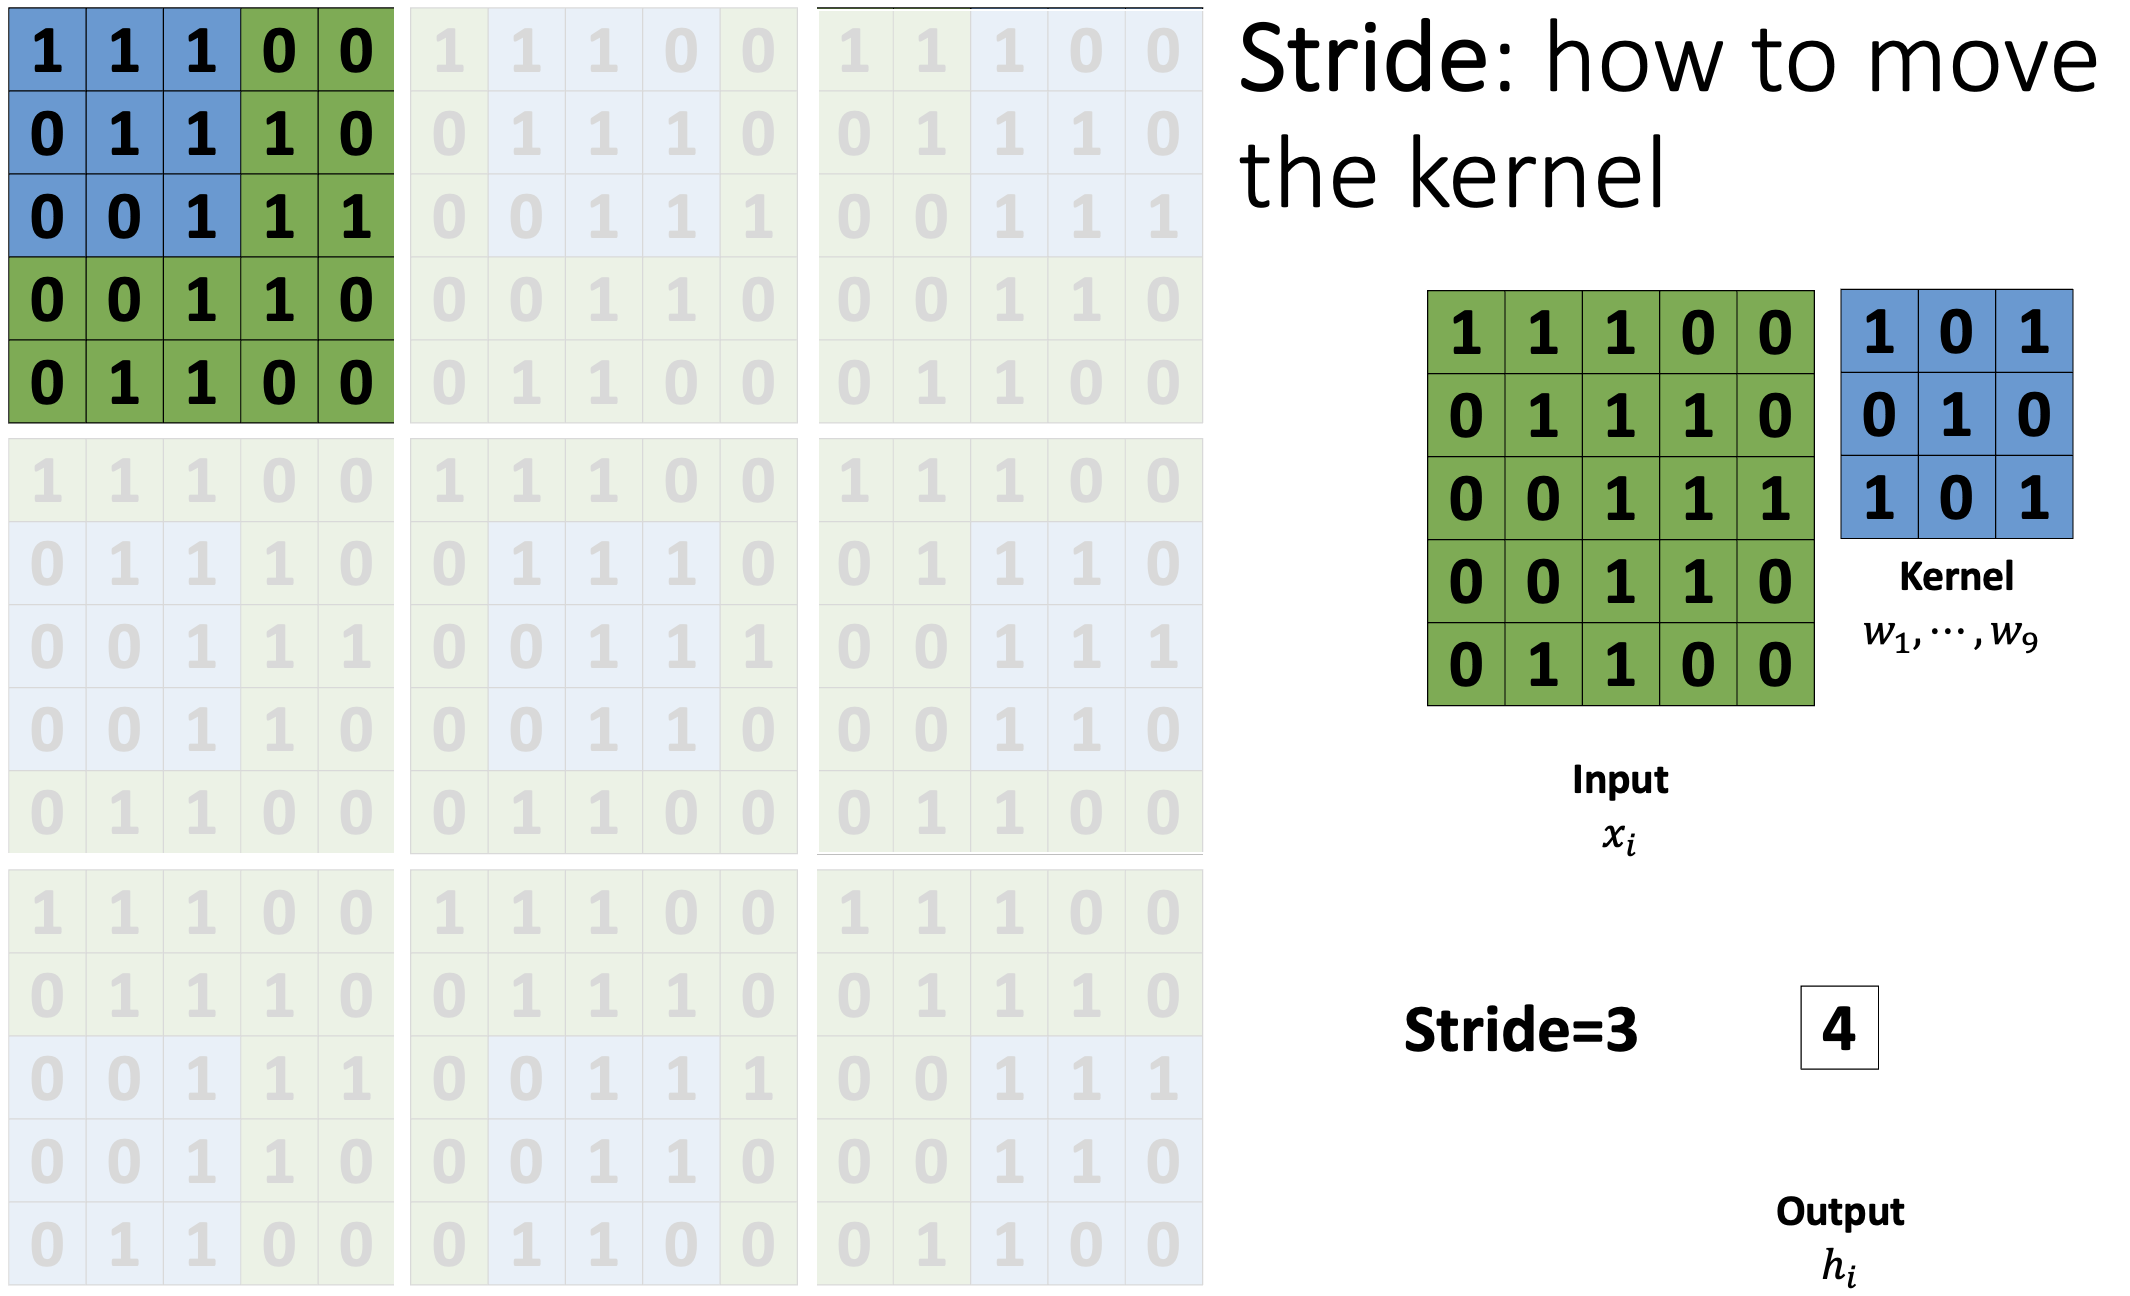

In [ ]:
#@title Solution
F.conv2d(input_sample, kernel, stride=(3,3), padding=(0,0), dilation=(1,1))

tensor([[[[4.]]]])

# Dilation

The idea is the same as the stride.

## Exercise

How would we reproduce the following?

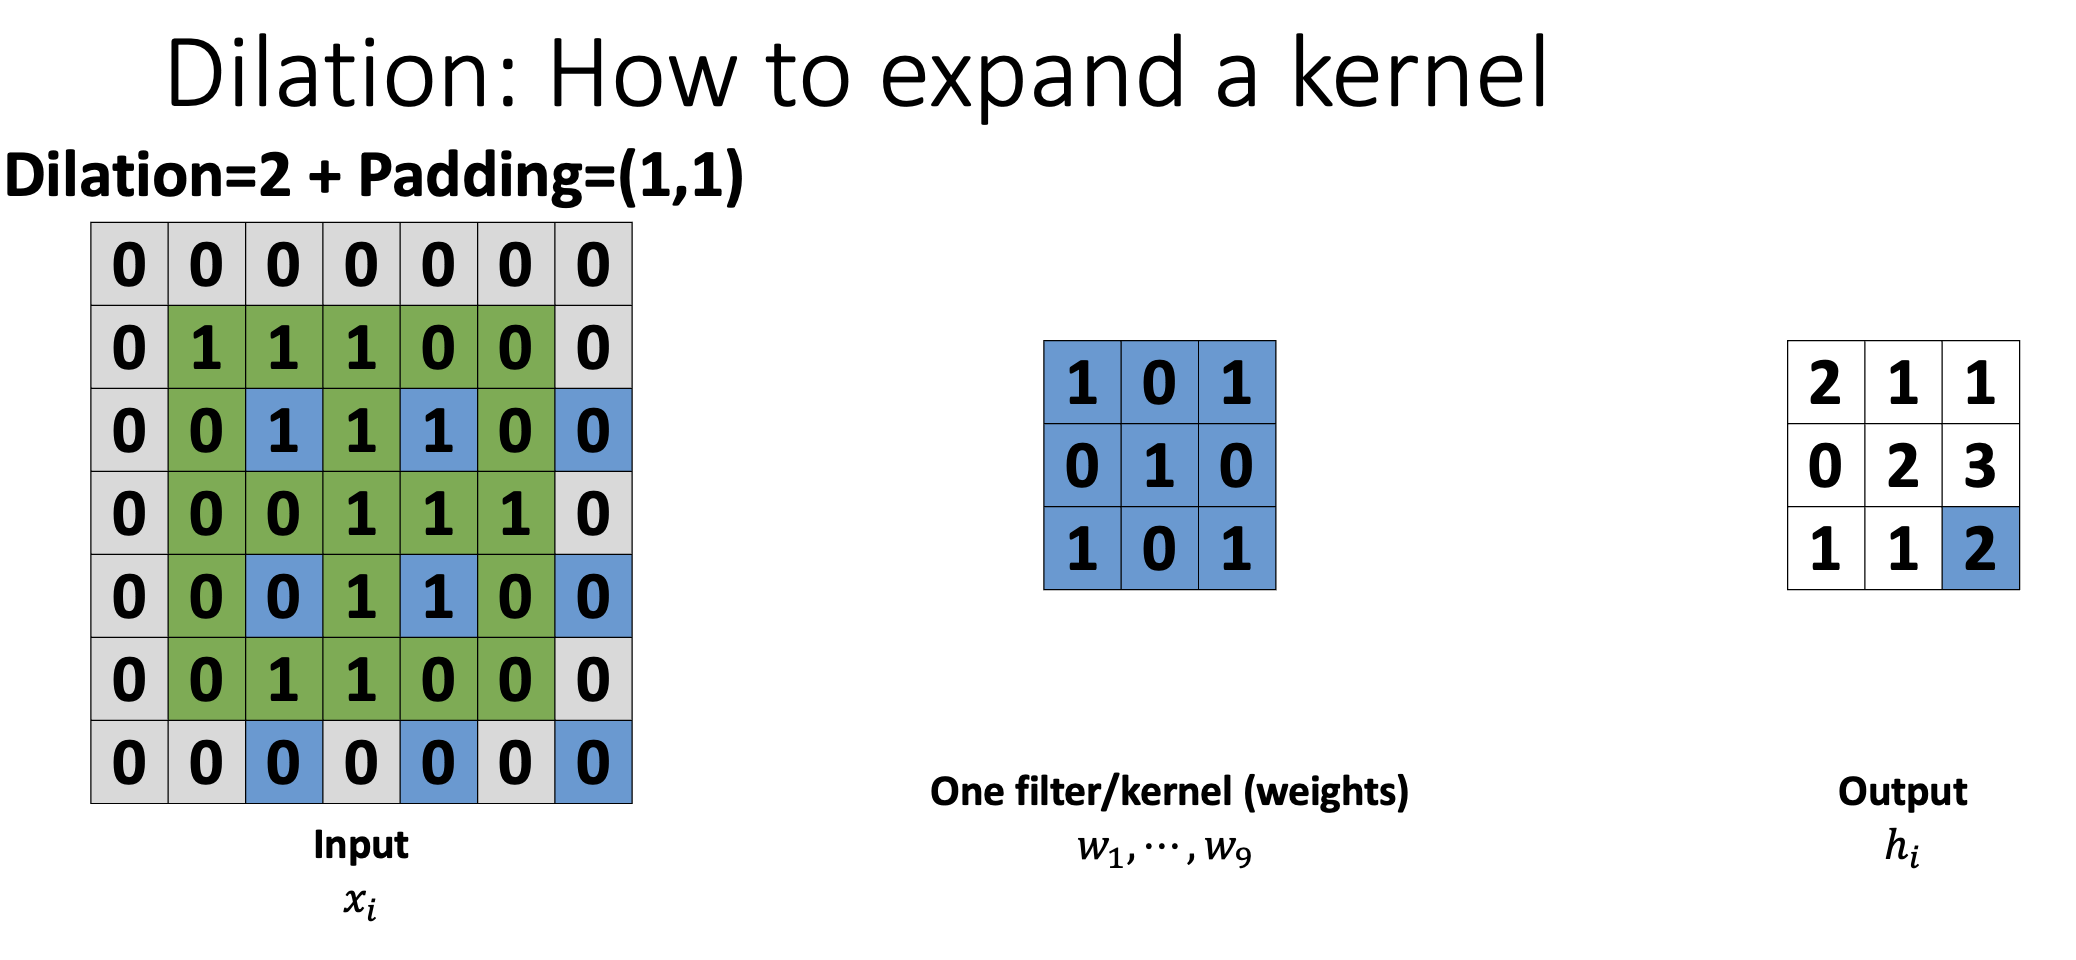

In [ ]:
#@title Solution
F.conv2d(input_sample, kernel, stride=(1,1), padding=(1,1), dilation=(2,2))

tensor([[[[2., 1., 1.],
          [0., 2., 3.],
          [1., 1., 2.]]]])

As for the stride, we can dilate only in one dimension if we want

In [ ]:
F.conv2d(input_sample, kernel, stride=(1,1), padding=(1,1), dilation=(1,2))

tensor([[[[2., 1., 1.],
          [2., 3., 2.],
          [2., 1., 2.],
          [1., 2., 2.],
          [2., 1., 0.]]]])

In [ ]:
F.conv2d(input_sample, kernel, stride=(1,1), padding=(1,1), dilation=(2,1))

tensor([[[[0., 2., 2., 2., 1.],
          [2., 3., 3., 3., 1.],
          [1., 1., 3., 2., 1.]]]])

# Multiple filters/kernels

Now it's time to convolve with multiple kernels! The code is **exactly** the same. The only difference will be the dimension of the kernel tensor

Before:

In [ ]:
kernel.size()

torch.Size([1, 1, 3, 3])

After:

In [ ]:
multi_kernel = torch.tensor(
[
  [[1, 0, 1],
  [0, 1, 0],
  [1, 0, 1]],
 
 [[0, 1, 0],
  [1, 0, 1],
  [0, 1, 0]],
]
).float().unsqueeze(1)
multi_kernel

tensor([[[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]]])

In [ ]:
multi_kernel.size()

torch.Size([2, 1, 3, 3])

Unlike before, we now have two kernels. Therefore, we would expect to have two outputs! Let's see

In [ ]:
output = F.conv2d(input_sample, kernel)
output, output.size()

(tensor([[[[4., 3., 4.],
           [2., 4., 3.],
           [2., 3., 4.]]]]), torch.Size([1, 1, 3, 3]))

In [ ]:
output = F.conv2d(input_sample, multi_kernel)
output, output.size()

(tensor([[[[4., 3., 4.],
           [2., 4., 3.],
           [2., 3., 4.]],
 
          [[2., 4., 2.],
           [2., 3., 4.],
           [2., 3., 2.]]]]), torch.Size([1, 2, 3, 3]))

# Max pooling

Finally, we apply convolutions with multiple kernels and we obtain many outputs. Max or average pooling is a standard way of reducing dimensionality.

The behavior is very similar to before. Let's see the example in the course

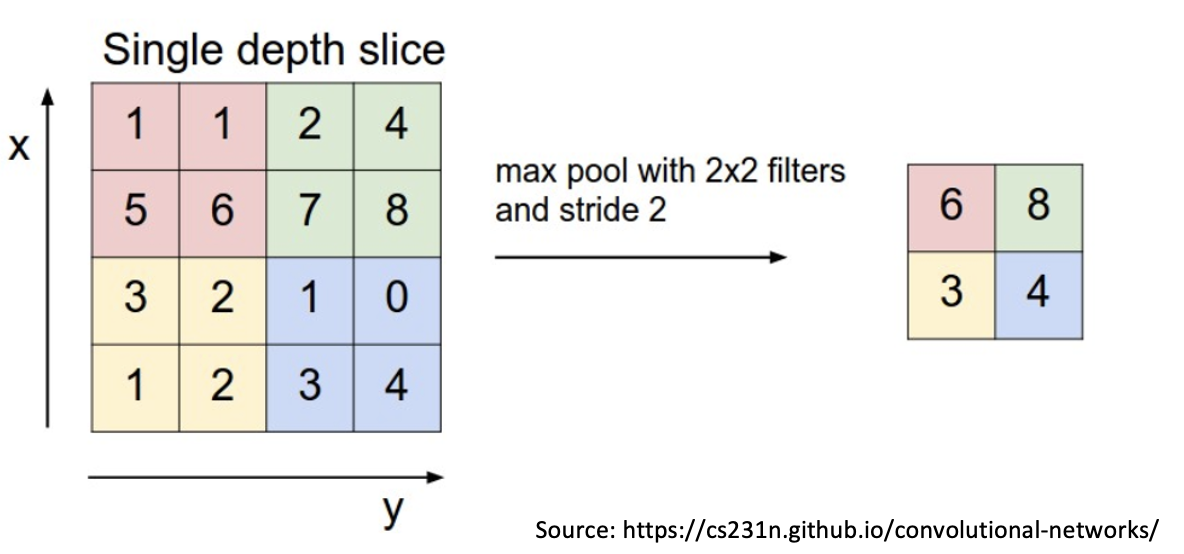

We create our input vector

In [ ]:
sample = torch.tensor(
    [[1,1,2,4],
     [5,6,7,8],
     [3,2,1,0],
     [1,2,3,4]]
).float().unsqueeze(0)

We use the function `max_pool2d()`. The important parameter to specifcy is `kernel_size` which corresponds to the size of the window with which we apply the reduction.

In [ ]:
F.max_pool2d(sample, kernel_size=2)

tensor([[[6., 8.],
         [3., 4.]]])

And also the mean pooling

In [ ]:
F.avg_pool2d(sample, kernel_size=2)

tensor([[[3.2500, 5.2500],
         [2.0000, 2.0000]]])